In [10]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
#from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
#from gammapy.irf.energy_dispersion import EnergyDispersion2D
#from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

ImportError: cannot import name 'make_region' from 'gammapy.utils.regions' (/Users/cedrickperron/anaconda3/envs/myenv/lib/python3.11/site-packages/gammapy/utils/regions.py)

In [5]:
#source = "crab_created_in_cluster"
source = "crab_A_weather"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")


obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")

NameError: name 'DataStore' is not defined

In [4]:
hdu_table

NameError: name 'hdu_table' is not defined

In [15]:
obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
97312,84.17265,22.014683,27.260061,62.73994,103.51672,248.76668,217.77345,0.87541246,502431040.0,502431300.0,4,"T1,T2,T3,T4"
97374,84.38838,22.014275,43.862484,46.137516,90.39276,900.2972,807.27856,0.8966801,502856930.0,502857820.0,4,"T1,T2,T3,T4"
97401,83.63451,21.514473,33.519394,56.480606,98.6108,1800.2872,1594.5498,0.88571966,503031580.0,503033380.0,4,"T1,T2,T3,T4"
97405,83.63215,22.51447,11.515071,78.48493,143.13852,1800.3235,1589.502,0.882898,503038430.0,503040220.0,4,"T1,T2,T3,T4"
97407,84.17265,22.014685,11.9462805,78.05372,216.64021,1800.3319,1568.3962,0.8711706,503042140.0,503043970.0,4,"T1,T2,T3,T4"
97412,84.17265,22.014685,37.925858,52.074142,265.6947,1800.2953,1601.6852,0.88967913,503050200.0,503052000.0,4,"T1,T2,T3,T4"
97414,83.63215,22.51447,51.360497,38.639503,274.71603,1800.2806,1630.6052,0.9057506,503053920.0,503055740.0,4,"T1,T2,T3,T4"
97437,83.63167,22.71447,39.37211,50.62789,267.69492,1500.2408,1340.7301,0.89367664,503136900.0,503138400.0,4,"T1,T2,T3,T4"


In [16]:
zenith_angle = list(obs_table["ZEN_PNT"])

azimuth_angle = list(obs_table["AZ_PNT"])
obs_id_list = list(obs_table["OBS_ID"])




total_obs_id = [[],[],[],[]]

for ind, az in enumerate(azimuth_angle):
    if (az >= 0) and (az < 90):
        total_obs_id[0].append(obs_id_list[ind])
    if (az >= 90) and (az < 180):
        total_obs_id[1].append(obs_id_list[ind])
    if (az >= 180) and (az < 270):
        total_obs_id[2].append(obs_id_list[ind])
    if (az >= 270) and (az < 360):
        total_obs_id[3].append(obs_id_list[ind])
        
total_obs_id.append(obs_id_list)
total_observations = []
print(total_obs_id)
name = ['0 to 90', "90 to 180", "180 to 270", "270 to 360", "Full"]
for ind, obs_id in enumerate(total_obs_id):
    if len(obs_id) == 0:
        print(name[ind], "has 0 observations")
        total_observations.append([])
    else:
        #print(data_store.get_observations(obs_id))
        total_observations.append(data_store.get_observations(obs_id))
        print(name[ind], f"has {len(obs_id)} observations")
        

    

[[], [97312, 97374, 97401, 97405, 97316, 97400, 97403], [97407, 97412, 97437, 97406, 97411, 97438], [97414, 97440, 97413, 97415, 97487], [97312, 97374, 97401, 97405, 97407, 97412, 97414, 97437, 97440, 97316, 97400, 97403, 97406, 97411, 97413, 97415, 97438, 97487]]
0 to 90 has 0 observations
90 to 180 has 7 observations
180 to 270 has 6 observations
270 to 360 has 5 observations
Full has 18 observations


In [17]:
# Target + On region
target_position = SkyCoord(ra="05h34m30.9s",dec="+22d00m44.5s", frame="icrs")
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

In [18]:
# Energy Axis
energy_axis = MapAxis.from_energy_bounds(0.2, 10.0, 15, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.1, 17, 20, unit="TeV", name="energy_true")





(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ffa3bebcb70>)

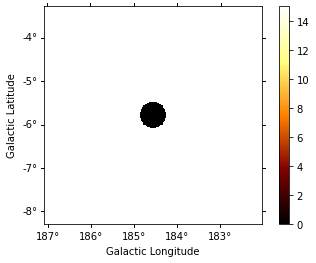

In [19]:
#TODO Take the same exclusion region as Tobias, because you end up with having -600 excess... 
# Exclusion Region 
df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])
region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.3)"))
exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

# 0.089
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="5 deg", frame="galactic", axes=[energy_axis])
center_region = CircleSkyRegion(center=target_position, radius=0.30* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [20]:
# Dataset Maker
dataset_empty = MapDatasetOnOff.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25)

# Contains all the IRFs: aeff is included. No need to specify
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)

bkg_maker = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)


In [21]:
%%time
list_of_datasets = []
list_of_stacked = []
count = 0


for ind, observations in enumerate(total_observations):
    stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true,binsz_irf=0.25, name=f"stacked_{name[ind]}")
    datasets = Datasets()
    for obs in observations:
        dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}_{name[ind]}"), obs)
        dataset = safe_mask_maker.run(dataset, obs)
        dataset = bkg_maker.run(dataset, obs)
        #dataset.background = dataset.background * exclusion_mask
        print(dataset)
        stacked.stack(dataset)
        print(count, dataset)
        count += 1
        datasets.append(dataset)
    list_of_datasets.append(datasets)
    if (len(observations) != 0):
        list_of_stacked.append(stacked)
    else:
        list_of_stacked.append(None)
    print()
    
complete_datasets = list_of_datasets[-1]
list_of_datasets = list_of_datasets[:-1]
complete_stacked = list_of_stacked[-1]
list_of_stacked = list_of_stacked[:-1]
print(len(list_of_datasets))
    
    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97312_90 to 180 

  Total counts                    : 255 
  Total background counts         : 226.62
  Total excess counts             : 28.38

  Predicted counts                : 205.97
  Predicted background counts     : 205.97
  Predicted excess counts         : 0.00

  Exposure min                    : 1.52e+03 m2 s
  Exposure max                    : 3.86e+07 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3933.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97312_90 to 180-bkg
    Datasets names            : ['97312_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.909              
      t

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97374_90 to 180 

  Total counts                    : 862 
  Total background counts         : 696.17
  Total excess counts             : 165.83

  Predicted counts                : 781.69
  Predicted background counts     : 781.69
  Predicted excess counts         : 0.00

  Exposure min                    : 2.19e+01 m2 s
  Exposure max                    : 2.34e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360855 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10938.35

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97374_90 to 180-bkg
    Datasets names            : ['97374_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.123              
     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97401_90 to 180 

  Total counts                    : 1632 
  Total background counts         : 1391.84
  Total excess counts             : 240.16

  Predicted counts                : 1339.00
  Predicted background counts     : 1339.00
  Predicted excess counts         : 0.00

  Exposure min                    : 1.19e+03 m2 s
  Exposure max                    : 3.27e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19251.59

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97401_90 to 180-bkg
    Datasets names            : ['97401_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.962              
 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97405_90 to 180 

  Total counts                    : 2344 
  Total background counts         : 1361.53
  Total excess counts             : 982.47

  Predicted counts                : 2028.60
  Predicted background counts     : 2028.60
  Predicted excess counts         : 0.00

  Exposure min                    : 1.17e+05 m2 s
  Exposure max                    : 2.41e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26609.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97405_90 to 180-bkg
    Datasets names            : ['97405_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.490              
 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97316_90 to 180 

  Total counts                    : 978 
  Total background counts         : 682.90
  Total excess counts             : 295.10

  Predicted counts                : 867.19
  Predicted background counts     : 867.19
  Predicted excess counts         : 0.00

  Exposure min                    : 1.40e+01 m2 s
  Exposure max                    : 2.06e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12587.61

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97316_90 to 180-bkg
    Datasets names            : ['97316_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.270              
     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97400_90 to 180 

  Total counts                    : 1699 
  Total background counts         : 1361.48
  Total excess counts             : 337.52

  Predicted counts                : 1471.28
  Predicted background counts     : 1471.28
  Predicted excess counts         : 0.00

  Exposure min                    : 2.35e+01 m2 s
  Exposure max                    : 3.89e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20011.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97400_90 to 180-bkg
    Datasets names            : ['97400_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.081              
 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97403_90 to 180 

  Total counts                    : 2457 
  Total background counts         : 1391.82
  Total excess counts             : 1065.18

  Predicted counts                : 2180.42
  Predicted background counts     : 2180.42
  Predicted excess counts         : 0.00

  Exposure min                    : 1.04e+05 m2 s
  Exposure max                    : 2.58e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360705 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 33415.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97403_90 to 180-bkg
    Datasets names            : ['97403_90 to 180']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.567              


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97407_180 to 270 

  Total counts                    : 2075 
  Total background counts         : 1361.78
  Total excess counts             : 713.22

  Predicted counts                : 1754.08
  Predicted background counts     : 1754.08
  Predicted excess counts         : 0.00

  Exposure min                    : 1.49e+05 m2 s
  Exposure max                    : 2.40e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24179.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97407_180 to 270-bkg
    Datasets names            : ['97407_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.288             

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97412_180 to 270 

  Total counts                    : 1434 
  Total background counts         : 1640.04
  Total excess counts             : -206.04

  Predicted counts                : 1195.26
  Predicted background counts     : 1195.26
  Predicted excess counts         : 0.00

  Exposure min                    : 7.11e+02 m2 s
  Exposure max                    : 4.02e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18219.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97412_180 to 270-bkg
    Datasets names            : ['97412_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.729            

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97437_180 to 270 

  Total counts                    : 1212 
  Total background counts         : 1506.93
  Total excess counts             : -294.93

  Predicted counts                : 1053.44
  Predicted background counts     : 1053.44
  Predicted excess counts         : 0.00

  Exposure min                    : 2.22e+02 m2 s
  Exposure max                    : 3.43e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360885 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16699.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97437_180 to 270-bkg
    Datasets names            : ['97437_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.699            

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97406_180 to 270 

  Total counts                    : 2201 
  Total background counts         : 1391.86
  Total excess counts             : 809.14

  Predicted counts                : 1843.85
  Predicted background counts     : 1843.85
  Predicted excess counts         : 0.00

  Exposure min                    : 1.68e+05 m2 s
  Exposure max                    : 2.36e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 32602.08

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97406_180 to 270-bkg
    Datasets names            : ['97406_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.325             

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97411_180 to 270 

  Total counts                    : 1693 
  Total background counts         : 1391.84
  Total excess counts             : 301.16

  Predicted counts                : 1384.71
  Predicted background counts     : 1384.71
  Predicted excess counts         : 0.00

  Exposure min                    : 5.79e+03 m2 s
  Exposure max                    : 3.19e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21453.28

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97411_180 to 270-bkg
    Datasets names            : ['97411_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.995             

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97438_180 to 270 

  Total counts                    : 642 
  Total background counts         : 571.87
  Total excess counts             : 70.13

  Predicted counts                : 560.59
  Predicted background counts     : 560.59
  Predicted excess counts         : 0.00

  Exposure min                    : 3.21e+01 m2 s
  Exposure max                    : 2.04e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360855 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8440.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97438_180 to 270-bkg
    Datasets names            : ['97438_180 to 270']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.980              
    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97414_270 to 360 

  Total counts                    : 1685 
  Total background counts         : 1808.27
  Total excess counts             : -123.27

  Predicted counts                : 1547.65
  Predicted background counts     : 1547.65
  Predicted excess counts         : 0.00

  Exposure min                    : 7.62e-01 m2 s
  Exposure max                    : 5.94e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 25898.30

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97414_270 to 360-bkg
    Datasets names            : ['97414_270 to 360']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.856            

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97440_270 to 360 

  Total counts                    : 168 
  Total background counts         : 179.40
  Total excess counts             : -11.40

  Predicted counts                : 156.49
  Predicted background counts     : 156.49
  Predicted excess counts         : 0.00

  Exposure min                    : 9.21e-04 m2 s
  Exposure max                    : 5.97e+07 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 357975 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3338.83

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97440_270 to 360-bkg
    Datasets names            : ['97440_270 to 360']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.872              
   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97413_270 to 360 

  Total counts                    : 1604 
  Total background counts         : 1361.13
  Total excess counts             : 242.87

  Predicted counts                : 1419.34
  Predicted background counts     : 1419.34
  Predicted excess counts         : 0.00

  Exposure min                    : 6.02e-03 m2 s
  Exposure max                    : 5.19e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360705 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19797.92

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97413_270 to 360-bkg
    Datasets names            : ['97413_270 to 360']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.043             

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97415_270 to 360 

  Total counts                    : 1937 
  Total background counts         : 1391.84
  Total excess counts             : 545.16

  Predicted counts                : 1835.54
  Predicted background counts     : 1835.54
  Predicted excess counts         : 0.00

  Exposure min                    : 2.15e-01 m2 s
  Exposure max                    : 6.04e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22738.40

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97415_270 to 360-bkg
    Datasets names            : ['97415_270 to 360']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.319             

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97487_270 to 360 

  Total counts                    : 1185 
  Total background counts         : 997.82
  Total excess counts             : 187.18

  Predicted counts                : 1038.11
  Predicted background counts     : 1038.11
  Predicted excess counts         : 0.00

  Exposure min                    : 1.05e+02 m2 s
  Exposure max                    : 3.40e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360885 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14128.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97487_270 to 360-bkg
    Datasets names            : ['97487_270 to 360']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.040              

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97312_Full 

  Total counts                    : 255 
  Total background counts         : 226.62
  Total excess counts             : 28.38

  Predicted counts                : 205.97
  Predicted background counts     : 205.97
  Predicted excess counts         : 0.00

  Exposure min                    : 1.52e+03 m2 s
  Exposure max                    : 3.86e+07 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3933.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97312_Full-bkg
    Datasets names            : ['97312_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.909              
      tilt         (fr

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97374_Full 

  Total counts                    : 862 
  Total background counts         : 696.17
  Total excess counts             : 165.83

  Predicted counts                : 781.69
  Predicted background counts     : 781.69
  Predicted excess counts         : 0.00

  Exposure min                    : 2.19e+01 m2 s
  Exposure max                    : 2.34e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360855 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10938.35

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97374_Full-bkg
    Datasets names            : ['97374_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.123              
      tilt         (

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97401_Full 

  Total counts                    : 1632 
  Total background counts         : 1391.84
  Total excess counts             : 240.16

  Predicted counts                : 1339.00
  Predicted background counts     : 1339.00
  Predicted excess counts         : 0.00

  Exposure min                    : 1.19e+03 m2 s
  Exposure max                    : 3.27e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19251.59

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97401_Full-bkg
    Datasets names            : ['97401_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.962              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97405_Full 

  Total counts                    : 2344 
  Total background counts         : 1361.53
  Total excess counts             : 982.47

  Predicted counts                : 2028.60
  Predicted background counts     : 2028.60
  Predicted excess counts         : 0.00

  Exposure min                    : 1.17e+05 m2 s
  Exposure max                    : 2.41e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26609.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97405_Full-bkg
    Datasets names            : ['97405_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.490              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97407_Full 

  Total counts                    : 2075 
  Total background counts         : 1361.78
  Total excess counts             : 713.22

  Predicted counts                : 1754.08
  Predicted background counts     : 1754.08
  Predicted excess counts         : 0.00

  Exposure min                    : 1.49e+05 m2 s
  Exposure max                    : 2.40e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24179.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97407_Full-bkg
    Datasets names            : ['97407_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.288              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97412_Full 

  Total counts                    : 1434 
  Total background counts         : 1640.04
  Total excess counts             : -206.04

  Predicted counts                : 1195.26
  Predicted background counts     : 1195.26
  Predicted excess counts         : 0.00

  Exposure min                    : 7.11e+02 m2 s
  Exposure max                    : 4.02e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360990 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18219.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97412_Full-bkg
    Datasets names            : ['97412_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.729              
      tilt     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97414_Full 

  Total counts                    : 1685 
  Total background counts         : 1808.27
  Total excess counts             : -123.27

  Predicted counts                : 1547.65
  Predicted background counts     : 1547.65
  Predicted excess counts         : 0.00

  Exposure min                    : 7.62e-01 m2 s
  Exposure max                    : 5.94e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 25898.30

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97414_Full-bkg
    Datasets names            : ['97414_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.856              
      tilt     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97437_Full 

  Total counts                    : 1212 
  Total background counts         : 1506.93
  Total excess counts             : -294.93

  Predicted counts                : 1053.44
  Predicted background counts     : 1053.44
  Predicted excess counts         : 0.00

  Exposure min                    : 2.22e+02 m2 s
  Exposure max                    : 3.43e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360885 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16699.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97437_Full-bkg
    Datasets names            : ['97437_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.699              
      tilt     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97440_Full 

  Total counts                    : 168 
  Total background counts         : 179.40
  Total excess counts             : -11.40

  Predicted counts                : 156.49
  Predicted background counts     : 156.49
  Predicted excess counts         : 0.00

  Exposure min                    : 9.21e-04 m2 s
  Exposure max                    : 5.97e+07 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 357975 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3338.83

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97440_Full-bkg
    Datasets names            : ['97440_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.872              
      tilt         (f

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97316_Full 

  Total counts                    : 978 
  Total background counts         : 682.90
  Total excess counts             : 295.10

  Predicted counts                : 867.19
  Predicted background counts     : 867.19
  Predicted excess counts         : 0.00

  Exposure min                    : 1.40e+01 m2 s
  Exposure max                    : 2.06e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12587.61

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97316_Full-bkg
    Datasets names            : ['97316_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.270              
      tilt         (

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97400_Full 

  Total counts                    : 1699 
  Total background counts         : 1361.48
  Total excess counts             : 337.52

  Predicted counts                : 1471.28
  Predicted background counts     : 1471.28
  Predicted excess counts         : 0.00

  Exposure min                    : 2.35e+01 m2 s
  Exposure max                    : 3.89e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360870 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20011.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97400_Full-bkg
    Datasets names            : ['97400_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.081              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97403_Full 

  Total counts                    : 2457 
  Total background counts         : 1391.82
  Total excess counts             : 1065.18

  Predicted counts                : 2180.42
  Predicted background counts     : 2180.42
  Predicted excess counts         : 0.00

  Exposure min                    : 1.04e+05 m2 s
  Exposure max                    : 2.58e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360705 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 33415.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97403_Full-bkg
    Datasets names            : ['97403_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.567              
      tilt     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97406_Full 

  Total counts                    : 2201 
  Total background counts         : 1391.86
  Total excess counts             : 809.14

  Predicted counts                : 1843.85
  Predicted background counts     : 1843.85
  Predicted excess counts         : 0.00

  Exposure min                    : 1.68e+05 m2 s
  Exposure max                    : 2.36e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 32602.08

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97406_Full-bkg
    Datasets names            : ['97406_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.325              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97411_Full 

  Total counts                    : 1693 
  Total background counts         : 1391.84
  Total excess counts             : 301.16

  Predicted counts                : 1384.71
  Predicted background counts     : 1384.71
  Predicted excess counts         : 0.00

  Exposure min                    : 5.79e+03 m2 s
  Exposure max                    : 3.19e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21453.28

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97411_Full-bkg
    Datasets names            : ['97411_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.995              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97413_Full 

  Total counts                    : 1604 
  Total background counts         : 1361.13
  Total excess counts             : 242.87

  Predicted counts                : 1419.34
  Predicted background counts     : 1419.34
  Predicted excess counts         : 0.00

  Exposure min                    : 6.02e-03 m2 s
  Exposure max                    : 5.19e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360705 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19797.92

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97413_Full-bkg
    Datasets names            : ['97413_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.043              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


MapDataset
----------

  Name                            : 97415_Full 

  Total counts                    : 1937 
  Total background counts         : 1391.84
  Total excess counts             : 545.16

  Predicted counts                : 1835.54
  Predicted background counts     : 1835.54
  Predicted excess counts         : 0.00

  Exposure min                    : 2.15e-01 m2 s
  Exposure max                    : 6.04e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360720 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22738.40

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97415_Full-bkg
    Datasets names            : ['97415_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.319              
      tilt      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97438_Full 

  Total counts                    : 642 
  Total background counts         : 571.87
  Total excess counts             : 70.13

  Predicted counts                : 560.59
  Predicted background counts     : 560.59
  Predicted excess counts         : 0.00

  Exposure min                    : 3.21e+01 m2 s
  Exposure max                    : 2.04e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360855 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8440.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97438_Full-bkg
    Datasets names            : ['97438_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.980              
      tilt         (fr

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


MapDataset
----------

  Name                            : 97487_Full 

  Total counts                    : 1185 
  Total background counts         : 997.82
  Total excess counts             : 187.18

  Predicted counts                : 1038.11
  Predicted background counts     : 1038.11
  Predicted excess counts         : 0.00

  Exposure min                    : 1.05e+02 m2 s
  Exposure max                    : 3.40e+08 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 360885 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14128.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 97487_Full-bkg
    Datasets names            : ['97487_Full']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.040              
      tilt       

In [22]:
print(complete_stacked)

MapDataset
----------

  Name                            : stacked_Full 

  Total counts                    : 26063 
  Total background counts         : 22663.22
  Total excess counts             : 3399.78

  Predicted counts                : 22663.21
  Predicted background counts     : 22663.22
  Predicted excess counts         : nan

  Exposure min                    : 1.42e+02 m2 s
  Exposure max                    : 4.89e+09 m2 s

  Number of total bins            : 937500 
  Number of fit bins              : 666780 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [23]:
print(len(list_of_datasets))

4


In [24]:
%%cache
#index 0

index = 0

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

UsageError: Cell magic `%%cache` not found.


90 to 180


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str15,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97312_90 to 180,255.0,226.6226194835607,28.377380516439302,1.8476278054596345,205.97220516980317,205.97220516980317,0.0,1517.1467951530078,38601615.270550966,nan,248.76667392253876,1.025056917709975,0.9109846423967815,0.11407227531319361,937500,360990,cash,3933.7018666902845,27.260061,103.51672
97374_90 to 180,862.0,696.1691528174044,165.83084718259556,6.0574419798874715,781.691677162371,781.691677162371,0.0,21.899223137801208,233909207.5192854,nan,900.2971748709679,0.9574616294042502,0.7732659528973648,0.18419567650688531,937500,360855,cash,10938.352049510713,43.862484,90.39276
97401_90 to 180,1632.0,1391.8358621507773,240.1641378492227,6.264467916129616,1338.9995759721276,1338.9995759721276,0.0,1186.5695358973499,327396709.5540753,nan,1800.2872598171234,0.9065219959206853,0.7731187645532539,0.13340323136743135,937500,360720,cash,19251.58673988,33.519394,98.6108
97405_90 to 180,2344.0,1361.5263459174932,982.4736540825068,24.120935515647624,2028.5994968331356,2028.5994968331356,0.0,117402.63594269389,241485876.15477693,nan,1800.3234959840775,1.30198822890924,0.7562676091017005,0.5457206198075393,937500,360870,cash,26609.539776276044,11.515071,143.13852
97316_90 to 180,978.0,682.9018067853949,295.0981932146051,10.597996903014666,867.192032434275,867.192032434275,0.0,14.034691609094923,206291396.40804237,nan,903.2027333974838,1.0828133749342843,0.7560891719366196,0.32672420299766464,937500,360720,cash,12587.614544019088,41.061832,92.967384
97400_90 to 180,1699.0,1361.4848211081064,337.5151788918936,8.80370690332312,1471.280516667805,1471.280516667805,0.0,23.53303377254721,388592954.66657597,nan,1800.268588423729,0.9437480667746376,0.7562676091017003,0.18748045767293736,937500,360870,cash,20011.422948783154,39.97551,92.18513
97403_90 to 180,2457.0,1391.8216909331525,1065.1783090668475,25.737227444489662,2180.422998416082,2180.422998416082,0.0,104458.0508722148,258238635.20438305,nan,1800.3286049365997,1.3647508534068566,0.7730931381730541,0.5916577152338024,937500,360705,cash,33415.52322066968,20.479954,113.507996


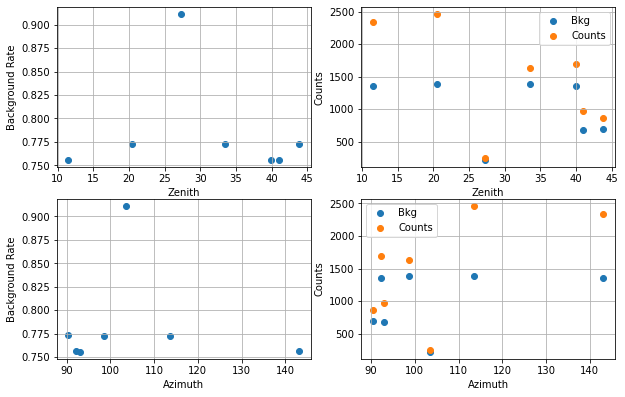

In [25]:
#index 1

index = 1

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

180 to 270


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str16,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97407_180 to 270,2075.0,1361.7790021615406,713.2209978384594,17.927925277565915,1754.0789236728488,1754.0789236728488,0.0,148986.54425640558,239922962.8888821,nan,1800.3319681882858,1.1525652138967009,0.756404388870531,0.39616082502616984,937500,360990,cash,24179.577412585335,11.9462805,216.64021
97412_180 to 270,1434.0,1640.0413606567852,-206.04136065678517,-5.200298230329545,1195.2629481839872,1195.2629481839872,0.0,710.5599572875798,402118395.3793907,nan,1800.2952900528908,0.796535994913296,0.910984642196449,-0.11444864728315314,937500,360990,cash,18219.518998775213,37.925858,265.6947
97437_180 to 270,1212.0,1506.9253581871894,-294.92535818718943,-7.867891617995939,1053.4387012161621,1053.4387012161621,0.0,221.67876338693947,343314155.9949182,nan,1500.2407945394516,0.8078703128267242,1.0044556604993466,-0.19658534767262245,937500,360885,cash,16699.122309108432,39.37211,267.69492
97406_180 to 270,2201.0,1391.855767870921,809.144232129079,19.97586163077284,1843.8512392168554,1843.8512392168554,0.0,167832.77074226478,235606224.53720504,nan,1800.3130071163177,1.222565182443185,0.7731187645532539,0.44944641788993106,937500,360720,cash,32602.08461778241,10.27231,181.60292
97411_180 to 270,1693.0,1391.841218983343,301.15878101665703,7.804797970698329,1384.7063109160936,1384.7063109160936,0.0,5793.88769956959,319336817.54075897,nan,1800.2941886782646,0.9404018580113078,0.7731187645532541,0.16728309345805367,937500,360720,cash,21453.278313332576,30.034603,258.2285
97438_180 to 270,642.0,571.8676346425099,70.13236535749013,2.8756245526819586,560.587998061324,560.587998061324,0.0,32.06634183806506,204165283.88454187,nan,739.5336358547211,0.8681146723745757,0.7732814397029689,0.09483323267160684,937500,360855,cash,8440.7907790863,44.00025,268.71747


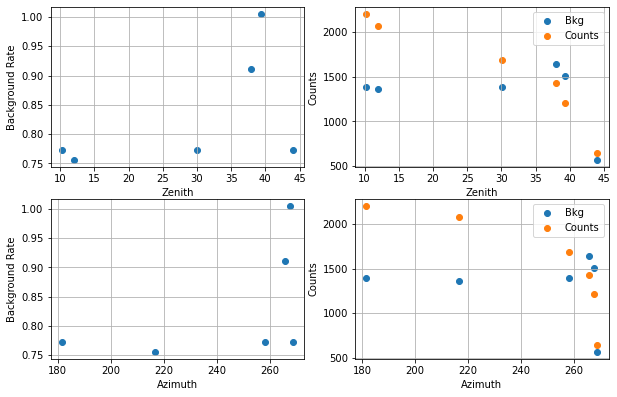

In [26]:
#index 2

index = 2

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

270 to 360


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str16,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97414_270 to 360,1685.0,1808.2705658068808,-123.27056580688077,-2.932956964980659,1547.6522945212935,1547.6522945212935,0.0,0.7621153176021611,594110467.8079677,nan,1800.2806250452995,0.9359651915142958,1.00443816405644,-0.06847297254214407,937500,360870,cash,25898.30048843262,51.360497,274.71603
97440_270 to 360,168.0,179.40314672222263,-11.40314672222263,-0.8605953546314198,156.49212925309234,156.49212925309234,0.0,0.0009206412187398188,59728114.84937606,nan,179.47535985708237,0.9360616417416837,0.9995976431811183,-0.06353600143943461,937500,357975,cash,3338.828626998062,53.721447,274.0269
97413_270 to 360,1604.0,1361.126494997601,242.87350500239904,6.400500777521039,1419.3360795868189,1419.3360795868189,0.0,0.006018511913167474,518769468.1814807,nan,1800.2781456708908,0.8909734331092789,0.756064554952626,0.13490887815665278,937500,360705,cash,19797.92495821232,45.207508,270.4436
97415_270 to 360,1937.0,1391.8373935762481,545.1626064237519,13.787419514362803,1835.5409237724975,1835.5409237724975,0.0,0.2153479020128786,603860861.440252,nan,1800.2892406582832,1.075938219400638,0.7731187645532542,0.3028194548473838,937500,360720,cash,22738.39559795506,58.287357,277.2382
97487_270 to 360,1185.0,997.8168265187973,187.18317348120274,5.753550304923383,1038.1083380677865,1038.1083380677865,0.0,105.12855022301773,340492343.1107743,nan,1290.3081592321396,0.9183852644202387,0.7733166835995182,0.1450685808207205,937500,360885,cash,14128.624529721992,43.09932,270.14764


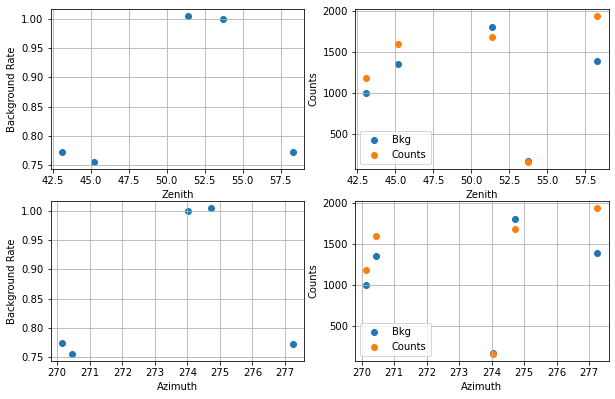

In [27]:
#index 3

index = 3

print(name[index])
a = list_of_datasets[index].info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate

fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

Full


name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str10,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
97312_Full,255.0,226.6226194835607,28.377380516439302,1.8476278054596345,205.97220516980317,205.97220516980317,0.0,1517.1467951530078,38601615.270550966,nan,248.76667392253876,1.025056917709975,0.9109846423967815,0.11407227531319361,937500,360990,cash,3933.7018666902845,27.260061,103.51672
97374_Full,862.0,696.1691528174044,165.83084718259556,6.0574419798874715,781.691677162371,781.691677162371,0.0,21.899223137801208,233909207.5192854,nan,900.2971748709679,0.9574616294042502,0.7732659528973648,0.18419567650688531,937500,360855,cash,10938.352049510713,43.862484,90.39276
97401_Full,1632.0,1391.8358621507773,240.1641378492227,6.264467916129616,1338.9995759721276,1338.9995759721276,0.0,1186.5695358973499,327396709.5540753,nan,1800.2872598171234,0.9065219959206853,0.7731187645532539,0.13340323136743135,937500,360720,cash,19251.58673988,33.519394,98.6108
97405_Full,2344.0,1361.5263459174932,982.4736540825068,24.120935515647624,2028.5994968331356,2028.5994968331356,0.0,117402.63594269389,241485876.15477693,nan,1800.3234959840775,1.30198822890924,0.7562676091017005,0.5457206198075393,937500,360870,cash,26609.539776276044,11.515071,143.13852
97407_Full,2075.0,1361.7790021615406,713.2209978384594,17.927925277565915,1754.0789236728488,1754.0789236728488,0.0,148986.54425640558,239922962.8888821,nan,1800.3319681882858,1.1525652138967009,0.756404388870531,0.39616082502616984,937500,360990,cash,24179.577412585335,11.9462805,216.64021
97412_Full,1434.0,1640.0413606567852,-206.04136065678517,-5.200298230329545,1195.2629481839872,1195.2629481839872,0.0,710.5599572875798,402118395.3793907,nan,1800.2952900528908,0.796535994913296,0.910984642196449,-0.11444864728315314,937500,360990,cash,18219.518998775213,37.925858,265.6947
97414_Full,1685.0,1808.2705658068808,-123.27056580688077,-2.932956964980659,1547.6522945212935,1547.6522945212935,0.0,0.7621153176021611,594110467.8079677,nan,1800.2806250452995,0.9359651915142958,1.00443816405644,-0.06847297254214407,937500,360870,cash,25898.30048843262,51.360497,274.71603
97437_Full,1212.0,1506.9253581871894,-294.92535818718943,-7.867891617995939,1053.4387012161621,1053.4387012161621,0.0,221.67876338693947,343314155.9949182,nan,1500.2407945394516,0.8078703128267242,1.0044556604993466,-0.19658534767262245,937500,360885,cash,16699.122309108432,39.37211,267.69492


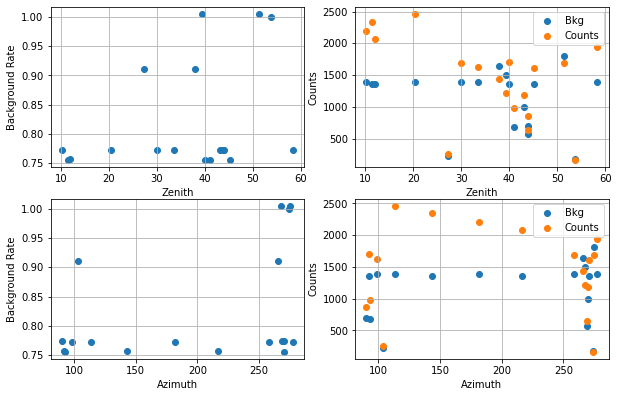

In [28]:
# Full Observations

index = -1

print(name[index])
a = complete_datasets.info_table(cumulative=False)



zen_col = []
az_col = []
for ind, obs_id in enumerate(obs_id_list):
    if obs_id in total_obs_id[index]:
        zen_col.append(list(obs_table["ZEN_PNT"])[ind])
        az_col.append(list(obs_table["AZ_PNT"])[ind])
from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

In [29]:
# Joint Models: Biggest Problem is that the model is the same for all dataset independent of the zenith angle
point_model = PointSpatialModel(lon_0="83.6333 deg", lat_0="22.0145 deg")#, evaluation_radius= "0.05 deg")
#point_model.parameters.free_parameters.freeze_all()
point_model.lat_0.frozen = True
point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2
spatial_model = point_model


spectral_model = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=1 * u.TeV)


model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
)


for datasets in list_of_datasets:
    for dataset in datasets:
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        bkg_model.spectral_model.norm.value = 1

models = Models([model, bkg_model])

# Joint Models
for datasets in list_of_datasets:
    datasets.models = models.copy()

# Stacked Models

for stacked in list_of_stacked:
    if stacked != None:
        stacked.models = models.copy()
    
    
# Full Observations:
complete_datasets.models = models.copy()
complete_stacked.models = models.copy()

In [30]:
%%time
#Model Fitting

# Joint Model
Fit_Res_Joint = []
for datasets in list_of_datasets:
    if len(datasets) != 0:
        fit_joint= Fit(datasets)
        result_joint = fit_joint.run()
        Fit_Res_Joint.append([fit_joint, result_joint])
    else:
        Fit_Res_Joint.append(None)

# Stacked Model
Fit_Res_Stacked = []
for dataset in list_of_stacked:
    if dataset != None:
        fit_stacked= Fit([dataset])
        result_stacked = fit_stacked.run()
        Fit_Res_Stacked.append([fit_stacked, result_stacked])
    else:
        Fit_Res_Stacked.append(None)

        
# Full Observations:
fit_full_joint = Fit(complete_datasets)
result_full_joint = fit_full_joint.run()

fit_full_stacked = Fit([complete_stacked])
result_full_stacked = fit_full_stacked.run()

CPU times: user 46.7 s, sys: 5.24 s, total: 52 s
Wall time: 1min 1s


In [31]:
# Joint
for ind in range(len(list_of_datasets)):
    if len(list_of_datasets[ind]) != 0:
        print(f"{name[ind]}")
        #print(Fit_Res_Joint[ind]) #USE Check if the fit was successful
        print(Fit_Res_Joint[ind][1].parameters.to_table())

print()
print("STACKED")
print()
# Stacked
for ind in range(len(list_of_stacked)):
    if list_of_stacked[ind] != None:
        print(f"{name[ind]}")
        #print(Fit_Res_Stacked[ind]) #USE Check if the fit was successful
        print(Fit_Res_Stacked[ind][1].parameters.to_table())
  

# Full Observations
print()
print("FULL_OBSERVATION")
print()

print(result_full_joint.parameters.to_table())
print()
print("STACKED")
print()
print(result_full_stacked.parameters.to_table())

90 to 180
   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.8159e+00                       nan       nan  False 3.561e-02
amplitude 5.4019e-11 cm-2 s-1 TeV-1        nan       nan  False 1.749e-12
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 8.3633e+01            deg        nan       nan   True 0.000e+00
    lat_0 2.2015e+01            deg -9.000e+01 9.000e+01   True 0.000e+00
180 to 270
   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.8142e+00                       nan       nan  False 3.590e-02
amplitude 4.3427e-11 cm-2 s-1 TeV-1        nan       nan  False 1.503e-12
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 8.3633e+01            deg        nan       nan   True 0.000e+00
    lat_0 2.2015e

In [32]:
# FLUX POINTS:
e_edges = MapAxis.from_energy_bounds("0.200 TeV", "12.589 TeV", nbin=15).edges
fpe = FluxPointsEstimator(energy_edges=e_edges)


# JOINT
list_of_flux_joint_datasets = []
for ind, datasets in enumerate(list_of_datasets):
    if len(datasets) != 0:
        flux_points = fpe.run(datasets=datasets)
        flux_points_datasets = FluxPointsDataset(data=flux_points, models=datasets.models)
        list_of_flux_joint_datasets.append(flux_points_datasets)
    else:
        list_of_flux_joint_datasets.append(None)



# STACKED
list_of_flux_stacked_datasets = []
for ind, stacked in enumerate(list_of_stacked):
    if stacked != None:
        flux_points = fpe.run(datasets=[stacked])
        flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)
        list_of_flux_stacked_datasets.append(flux_points_stacked)
    else:
        list_of_flux_stacked_datasets.append(None)

# Full (Stacked Only)

flux_points = fpe.run(datasets=[complete_stacked])
flux_points_full_stacked = FluxPointsDataset(data=flux_points, models=complete_stacked.models)

Value -100000.0 is outside bounds [-100000.0, 100000.0] for parameter 'norm'
Value -100000.0 is outside bounds [-100000.0, 100000.0] for parameter 'norm'
Value -100000.0 is outside bounds [-100000.0, 100000.0] for parameter 'norm'
Value -100000.0 is outside bounds [-100000.0, 100000.0] for parameter 'norm'
Value -100000.0 is outside bounds [-100000.0, 100000.0] for parameter 'norm'


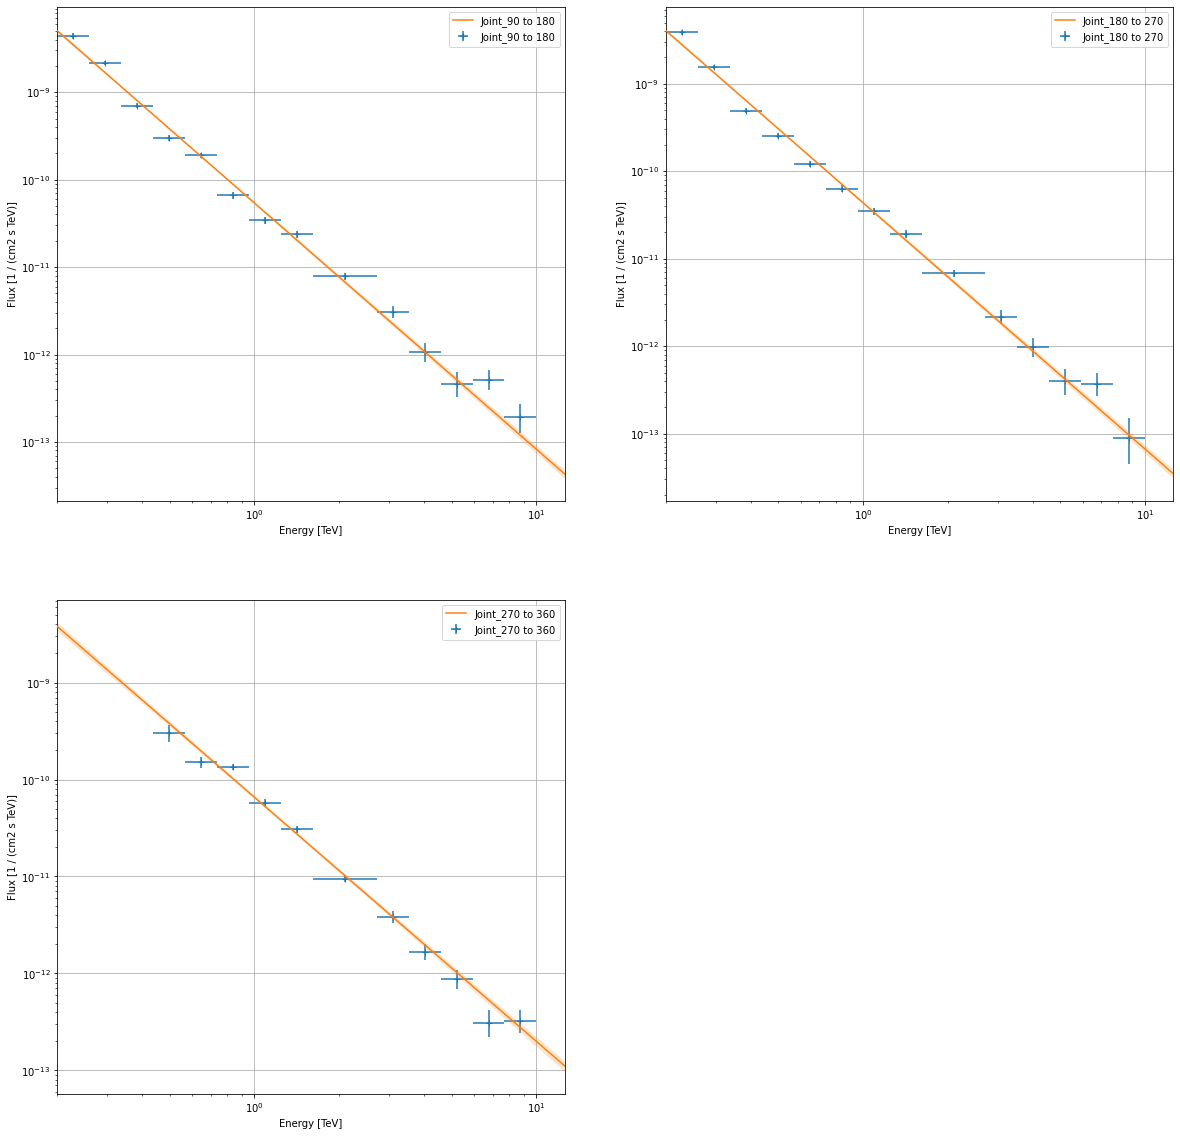

In [33]:
# JOINT SPECTRUM

count = 1 # number of plot
for datasets in list_of_flux_joint_datasets:
    if datasets != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))

for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        plt.subplot(count-2, 2, ind)
        datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plt.legend()
        plt.grid()

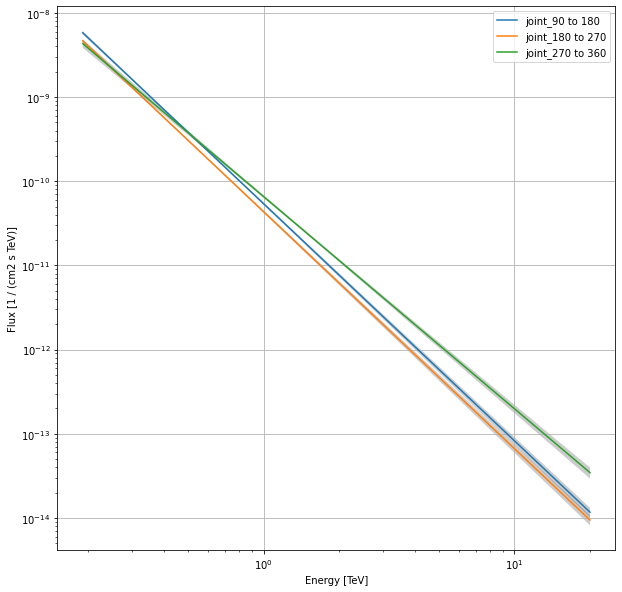

In [34]:
def plot_spectrum(model, result, label):
    spec = model.spectral_model
    energy_range = [0.19, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=0, label=label
    )
    spec.plot_error(energy_range=energy_range, energy_power=0)

plt.figure(figsize = (10, 10))
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Joint[ind][1], f"joint_{name[ind]}")
        plt.legend()
        plt.grid()

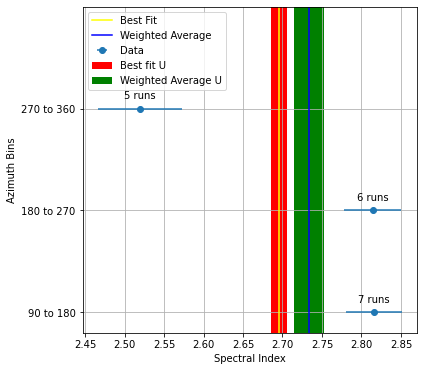

In [64]:
plt.figure(figsize=(6,6))
num_obs = [7,6,5]
index_list = []
name_list = []
index_error = []
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        name_list.append(name[ind])
        index_list.append(datasets.models[0].spectral_model.index.value)
        index_error.append(datasets.models[0].spectral_model.index.error)


plt.errorbar(x=index_list, y=name_list, xerr=index_error, fmt="o", label="Data")
# Best Fit
plt.bar(x = complete_datasets.models[0].spectral_model.index.value, width=complete_datasets.models[0].spectral_model.index.error, height = (-2, 3), color="red", label="Best fit U")
plt.axvline(x = complete_datasets.models[0].spectral_model.index.value, ymin = -2, ymax = 3, color="yellow", label="Best Fit")

    
weighted_avg = np.average(index_list, weights =num_obs)   
# Uncertainty:
num = 0

for [d, w] in zip(index_list, num_obs):
    num += w*(d-weighted_avg)**2

avg_err = 1/np.sqrt(18) *np.sqrt(num/(((len(num_obs)-1)/(len(num_obs)))*sum(num_obs)))

plt.bar(x = weighted_avg, width = avg_err, height = (-2, 3), color="green", label="Weighted Average U")
plt.axvline(x = weighted_avg, ymin = -2, ymax = 3, color="blue", label="Weighted Average")
count = 0 
for [x, y] in zip(index_list, name_list):
    label = f"{num_obs[count]} runs".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.ylim([-0.2, 3])
plt.xlabel("Spectral Index")
plt.ylabel("Azimuth Bins")
plt.legend()
plt.grid()

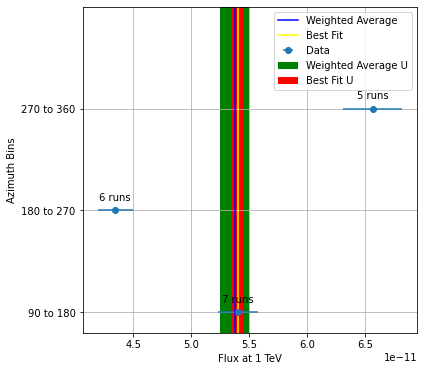

In [66]:
plt.figure(figsize=(6,6))
num_obs = [7,6,5]
amplitude_list = []
name_list = []
amplitude_error = []
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        name_list.append(name[ind])
        amplitude_list.append(datasets.models[0].spectral_model.amplitude.value)
        amplitude_error.append(datasets.models[0].spectral_model.amplitude.error)


plt.errorbar(x=amplitude_list, y=name_list, xerr=amplitude_error, fmt="o", label="Data")
# Best Fit

weighted_avg = np.average(amplitude_list, weights =num_obs)   
# Uncertainty:
num = 0

for [d, w] in zip(amplitude_list, num_obs):
    num += w*(d-weighted_avg)**2

avg_err = 1/np.sqrt(18) *np.sqrt(num/(((len(num_obs)-1)/(len(num_obs)))*sum(num_obs)))

plt.bar(x = weighted_avg, width = avg_err, height = (-2, 3), color="green", label="Weighted Average U")
plt.axvline(x = weighted_avg, ymin = -2, ymax = 3, color="blue", label="Weighted Average")
plt.bar(x = complete_datasets.models[0].spectral_model.amplitude.value, width=complete_datasets.models[0].spectral_model.amplitude.error, height = (-2, 3), color="red", label="Best Fit U")
plt.axvline(x = complete_datasets.models[0].spectral_model.amplitude.value, ymin = -2, ymax = 3, color="yellow", label="Best Fit")
count = 0 
for [x, y] in zip(amplitude_list, name_list):
    label = f"{num_obs[count]} runs".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

plt.ylim([-0.2, 3])
plt.xlabel("Flux at 1 TeV")
plt.ylabel("Azimuth Bins")
plt.legend()
plt.grid()

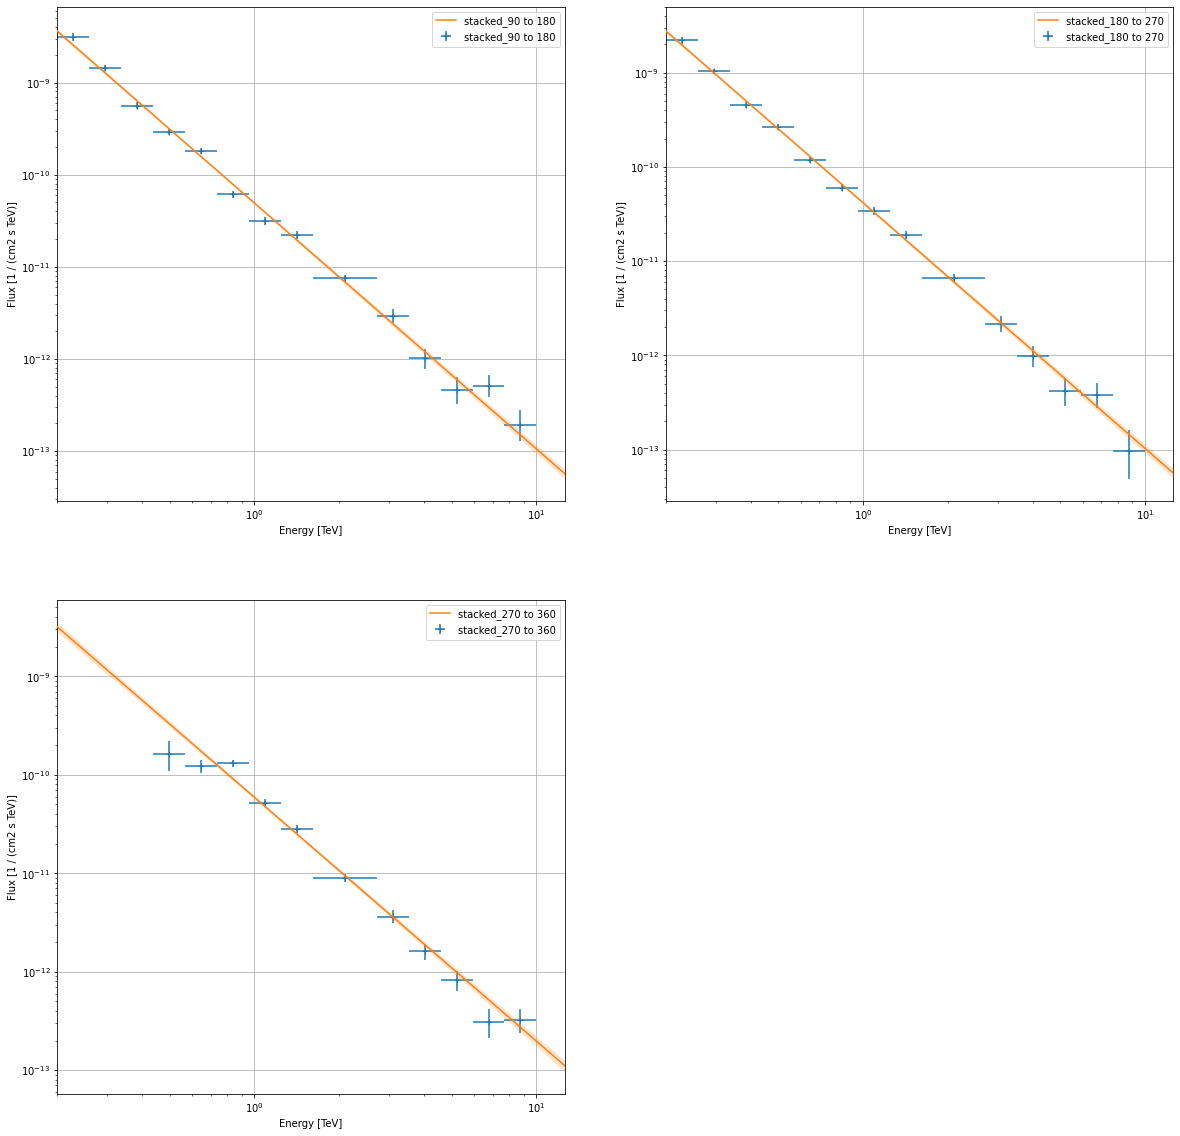

In [38]:
# Stacked SPECTRUM

count = 1 # number of plot
for stacked in list_of_flux_stacked_datasets:
    if stacked != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))

for ind, stacked in enumerate(list_of_flux_stacked_datasets):
    if stacked != None:
        plt.subplot(count-2, 2, ind)
        stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[ind]}");
        plt.legend()
        plt.grid()

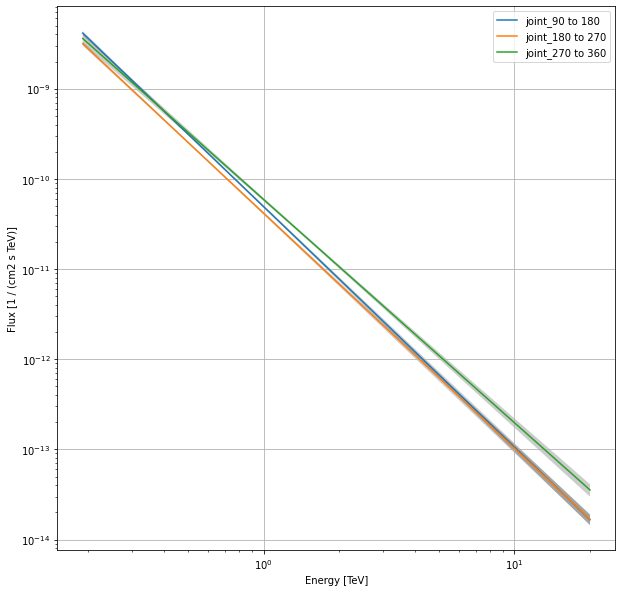

In [39]:
def plot_spectrum(model, result, label):
    spec = model.spectral_model
    energy_range = [0.19, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=0, label=label
    )
    spec.plot_error(energy_range=energy_range, energy_power=0)

plt.figure(figsize = (10, 10))
for ind, datasets in enumerate(list_of_flux_stacked_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Stacked[ind][1], f"joint_{name[ind]}")
        plt.legend()
        plt.grid()

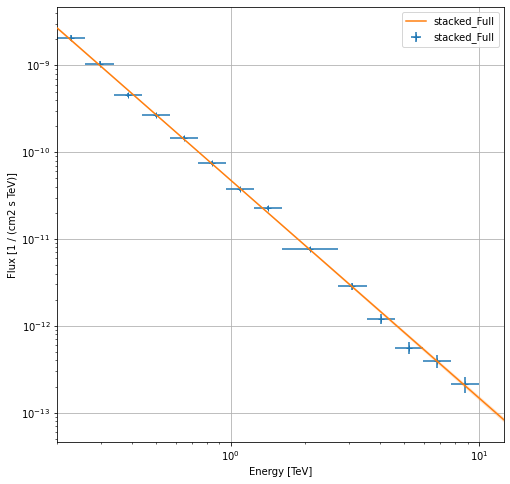

In [40]:
# Full observations
plt.figure(figsize = (8, 8))
flux_points_full_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[-1]}");
plt.legend()
plt.grid()

In [41]:
# FLUX POINTS:
e_edges = MapAxis.from_energy_bounds("1 TeV", "12.589 TeV", nbin=15).edges
fpe = FluxPointsEstimator(energy_edges=e_edges)


# JOINT
list_of_flux_joint_datasets = []
for ind, datasets in enumerate(list_of_datasets):
    if len(datasets) != 0:
        flux_points = fpe.run(datasets=datasets)
        flux_points_datasets = FluxPointsDataset(data=flux_points, models=datasets.models)
        list_of_flux_joint_datasets.append(flux_points_datasets)
    else:
        list_of_flux_joint_datasets.append(None)



# STACKED
list_of_flux_stacked_datasets = []
for ind, stacked in enumerate(list_of_stacked):
    if stacked != None:
        flux_points = fpe.run(datasets=[stacked])
        flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)
        list_of_flux_stacked_datasets.append(flux_points_stacked)
    else:
        list_of_flux_stacked_datasets.append(None)

# Full (Stacked Only)

flux_points = fpe.run(datasets=[complete_stacked])
flux_points_full_stacked = FluxPointsDataset(data=flux_points, models=complete_stacked.models)

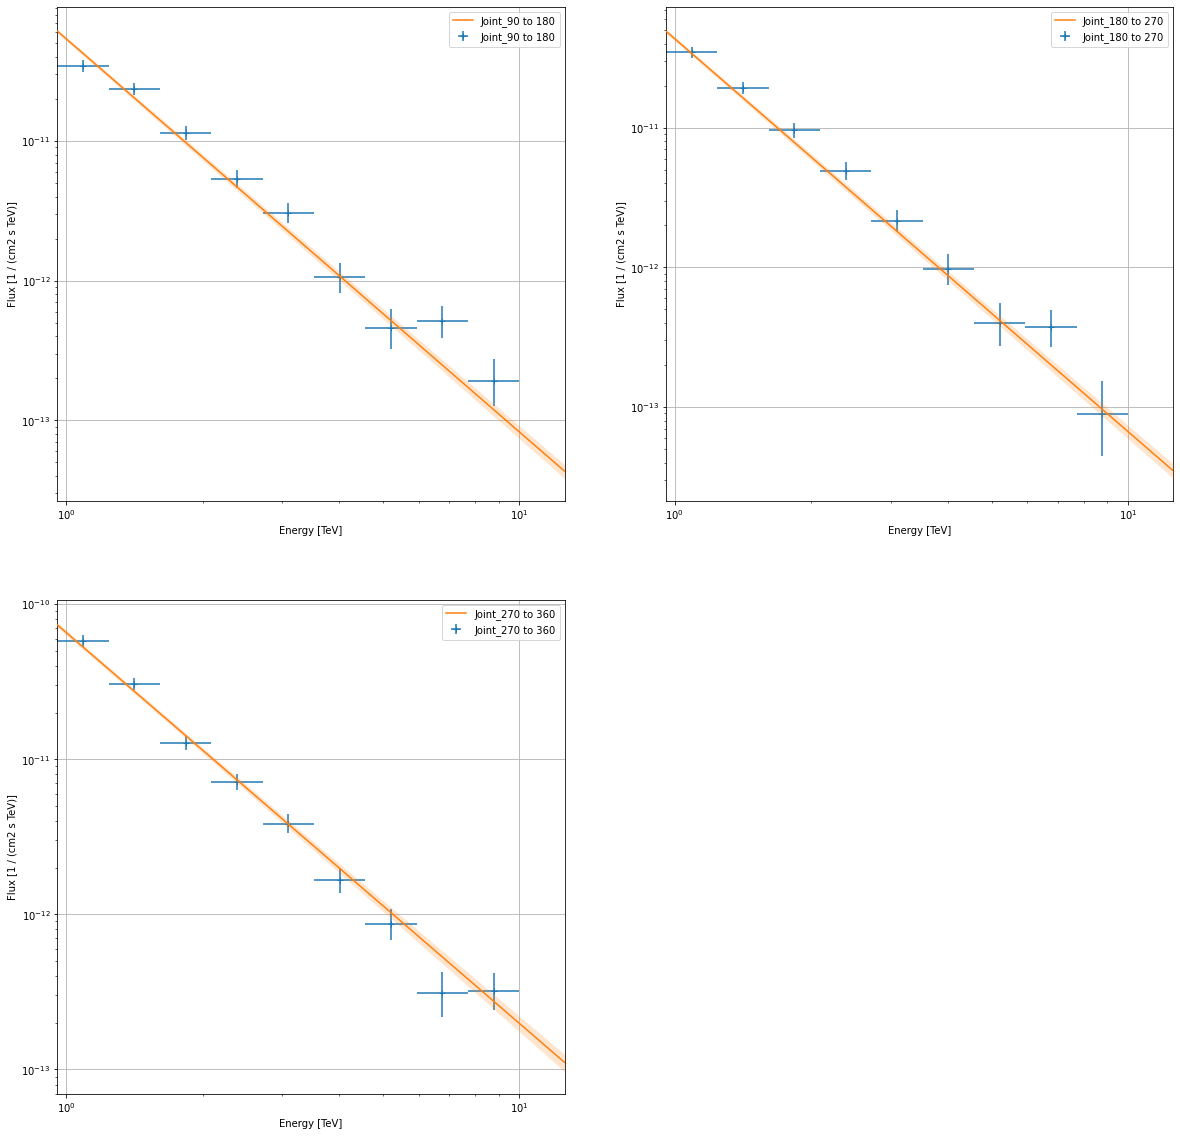

In [42]:

count = 1 # number of plot
for datasets in list_of_flux_joint_datasets:
    if datasets != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))

c = 1
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        plt.subplot(count-2, 2, c)
        datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1

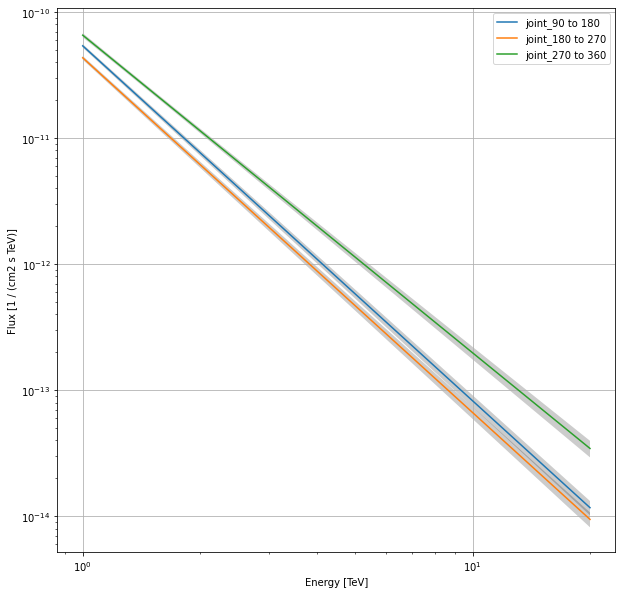

In [43]:
def plot_spectrum(model, result, label):
    spec = model.spectral_model
    energy_range = [1, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=0, label=label
    )
    spec.plot_error(energy_range=energy_range, energy_power=0)

plt.figure(figsize = (10, 10))
for ind, datasets in enumerate(list_of_flux_joint_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Joint[ind][1], f"joint_{name[ind]}")
        plt.legend()
        plt.grid()

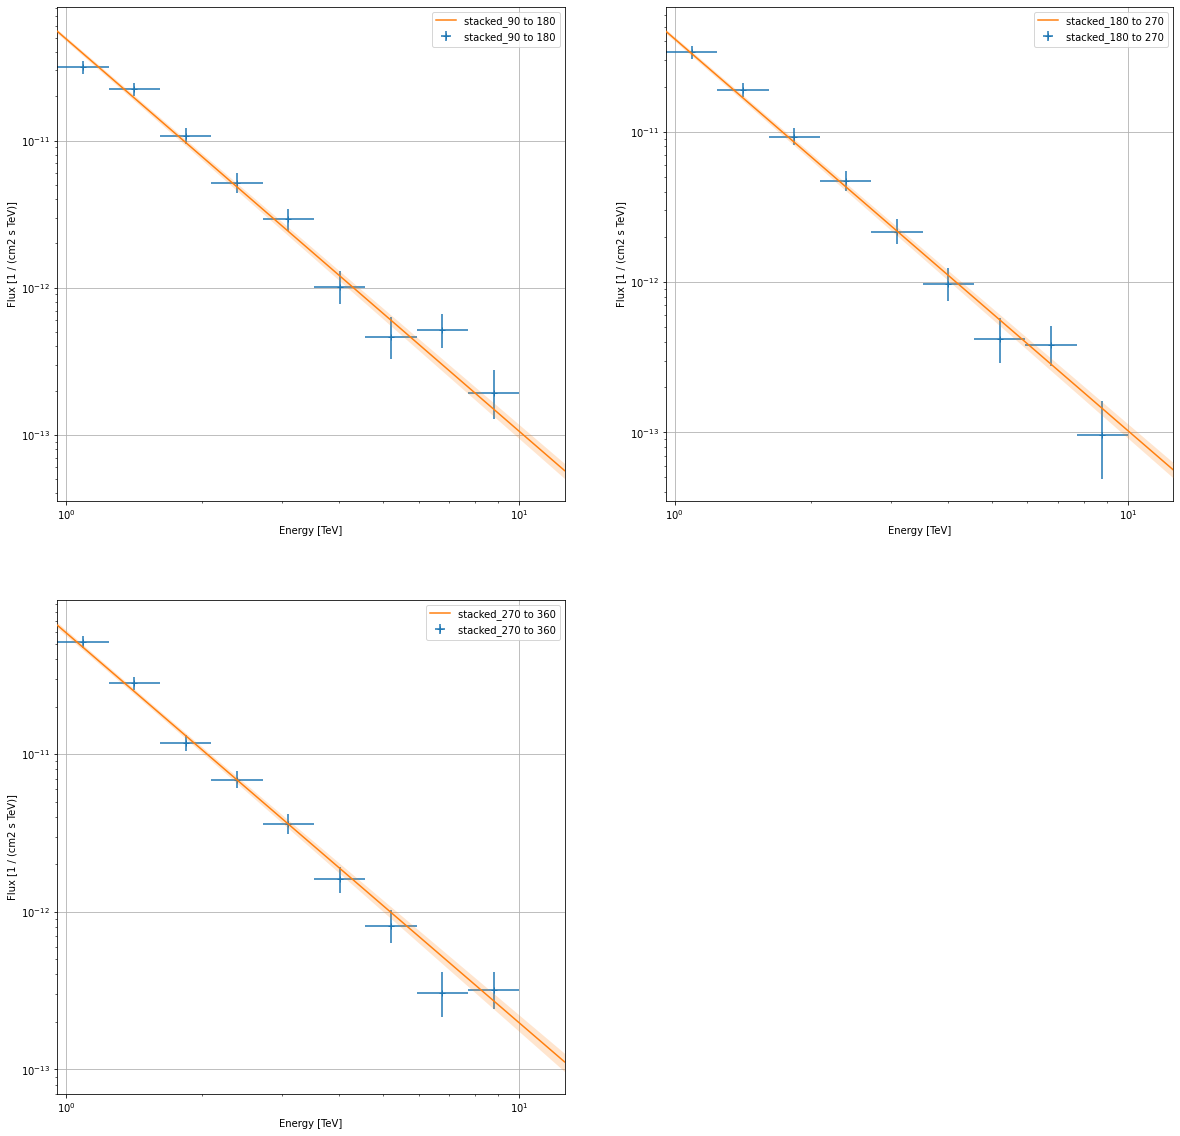

In [44]:
# Stacked SPECTRUM

count = 1 # number of plot
for stacked in list_of_flux_stacked_datasets:
    if stacked != None:
        count +=1

fig, axs = plt.subplots(count-3,2, figsize = (20, 20))
c = 1
for ind, stacked in enumerate(list_of_flux_stacked_datasets):
    if stacked != None:
        plt.subplot(count-2, 2, c)
        stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"stacked_{name[ind]}");
        plt.legend()
        plt.grid()
        c += 1

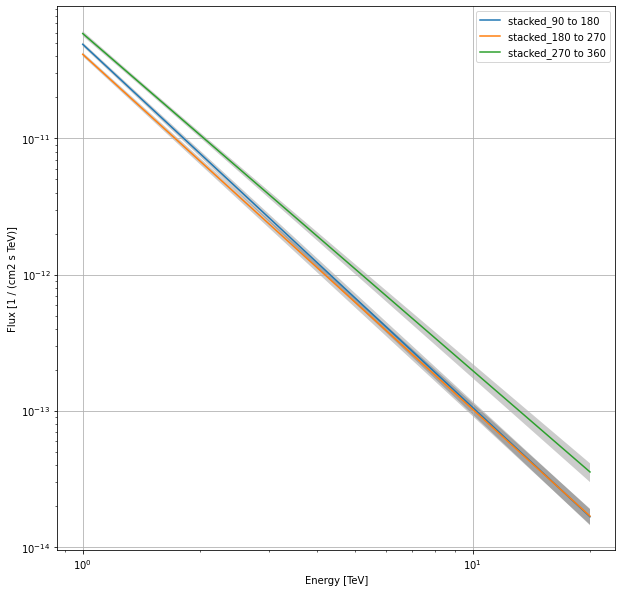

In [45]:
plt.figure(figsize=(10,10))
for ind, datasets in enumerate(list_of_flux_stacked_datasets):
    if datasets != None:
        #datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked_{name[ind]}");
        plot_spectrum(datasets.models[0], Fit_Res_Stacked[ind][1], f"stacked_{name[ind]}")
        plt.legend()
        plt.grid()

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
59217.174861346255,59217.17774059017,255.0,1.4142135623730951,0.2,10.000000000000002,2.1208014405377712e-11,4.870943090245853e-10,2.2211394545982502e-10,4.241602881075543e-11,0.9408852735214168,3702.905794097504,True,0.13462244546794633,223.36898616311237,0.14047161604799205,0.12887297128465625,1.2336966687094713,0.20000000000000004 .. 5.000000000000001,3768.3036938540185 .. 3984.40513065325,14.945533987218802,1.9954308434649958e-11,2.616425672185696e-11,2.8550747627713813e-12,2.9791240566925025e-12,2.733139831468818e-12,4.582998621773225e-10,6.009266263909726e-10,6.557382705440923e-11,6.842292475646354e-11,6.277329089984486e-11
59218.122922211616,59218.133375946956,978.0,1.4142135623730951,0.2,10.000000000000002,2.1208014405377712e-11,4.870943090245853e-10,2.2211394545982502e-10,4.241602881075543e-11,1.4436036406550556,12160.335016123665,True,0.12734998580808674,526.0057871722984,0.13058027034855102,0.12416262972798207,1.7113609381845836,0.20000000000000004 .. 5.000000000000001,12386.56054023184 .. 12507.577257214003,22.934816048364077,3.0615966806668134e-11,3.629456742981937e-11,2.700840333542551e-12,2.769348254610186e-12,2.6332428398806228e-12,7.031711178502501e-10,8.335941736766858e-10,6.203145334148076e-11,6.3604906557671e-11,6.047891033402686e-11
59222.10389424122,59222.11431434741,862.0,1.4142135623730951,0.2,10.000000000000002,2.1208014405377712e-11,4.870943090245853e-10,2.2211394545982502e-10,4.241602881075543e-11,0.9772578989650356,10678.466521563787,True,0.10625054122166687,288.5964313073673,0.10950770968394934,0.10310151619171305,1.2032149807314987,0.20000000000000004 .. 5.000000000000001,10785.827131637056 .. 11163.25231263037,16.988126185879576,2.072569959901963e-11,2.551780064411989e-11,2.2533630088082894e-12,2.322441084477118e-12,2.1865784406101337e-12,4.760167610351919e-10,5.860791696474391e-10,5.1754033959856044e-11,5.334058218136819e-11,5.022016178878956e-11
59224.103883063704,59224.1247195057,1699.0,1.4142135623730951,0.2,10.000000000000002,2.1208014405377712e-11,4.870943090245853e-10,2.2211394545982502e-10,4.241602881075543e-11,1.438479200238362,18968.239577829387,True,0.08974159449194603,1087.1314710292208,0.09138600444888481,0.08811976483013062,1.6246315999750098,0.20000000000000004 .. 5.000000000000001,19428.643094563864 .. 19659.70235366497,32.97167680038765,3.050728760049139e-11,3.445521037570185e-11,1.9032410287467567e-12,1.938115698801861e-12,1.8688452419159067e-12,7.00675032086343e-10,7.913488066093339e-10,4.371261995981898e-11,4.451360269154723e-11,4.2922635961341425e-11
59224.1254114728,59224.1462481309,1632.0,1.4142135623730951,0.2,10.000000000000002,2.1208014405377712e-11,4.870943090245853e-10,2.2211394545982502e-10,4.241602881075543e-11,1.1133647425158415,18105.99211390492,True,0.0655208783728122,1124.9474940115651,0.06665167092785002,0.06439865842224982,1.248947655933024,0.20000000000000004 .. 5.000000000000001,18535.970780753672 .. 19374.913183026114,33.5402369403015,2.3612255497715614e-11,2.6487699878590298e-11,1.3895677323836022e-12,1.413549597180338e-12,1.3657676755060728e-12,5.423136299480891e-10,6.083552954745718e-10,3.1914846977688854e-11,3.2465649595935145

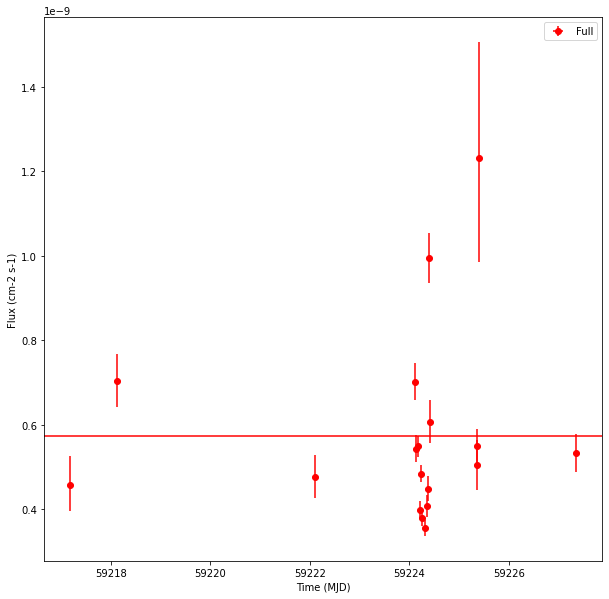

In [46]:
#Full Observations



lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)
lc_complete = lc_maker_1d.run(complete_datasets)

plt.figure(figsize=(10,10))
ax = lc_complete.plot(marker="o", color="red", label=f"{name[-1]}")
plt.axhline(y=lc_complete.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

lc_complete.table

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


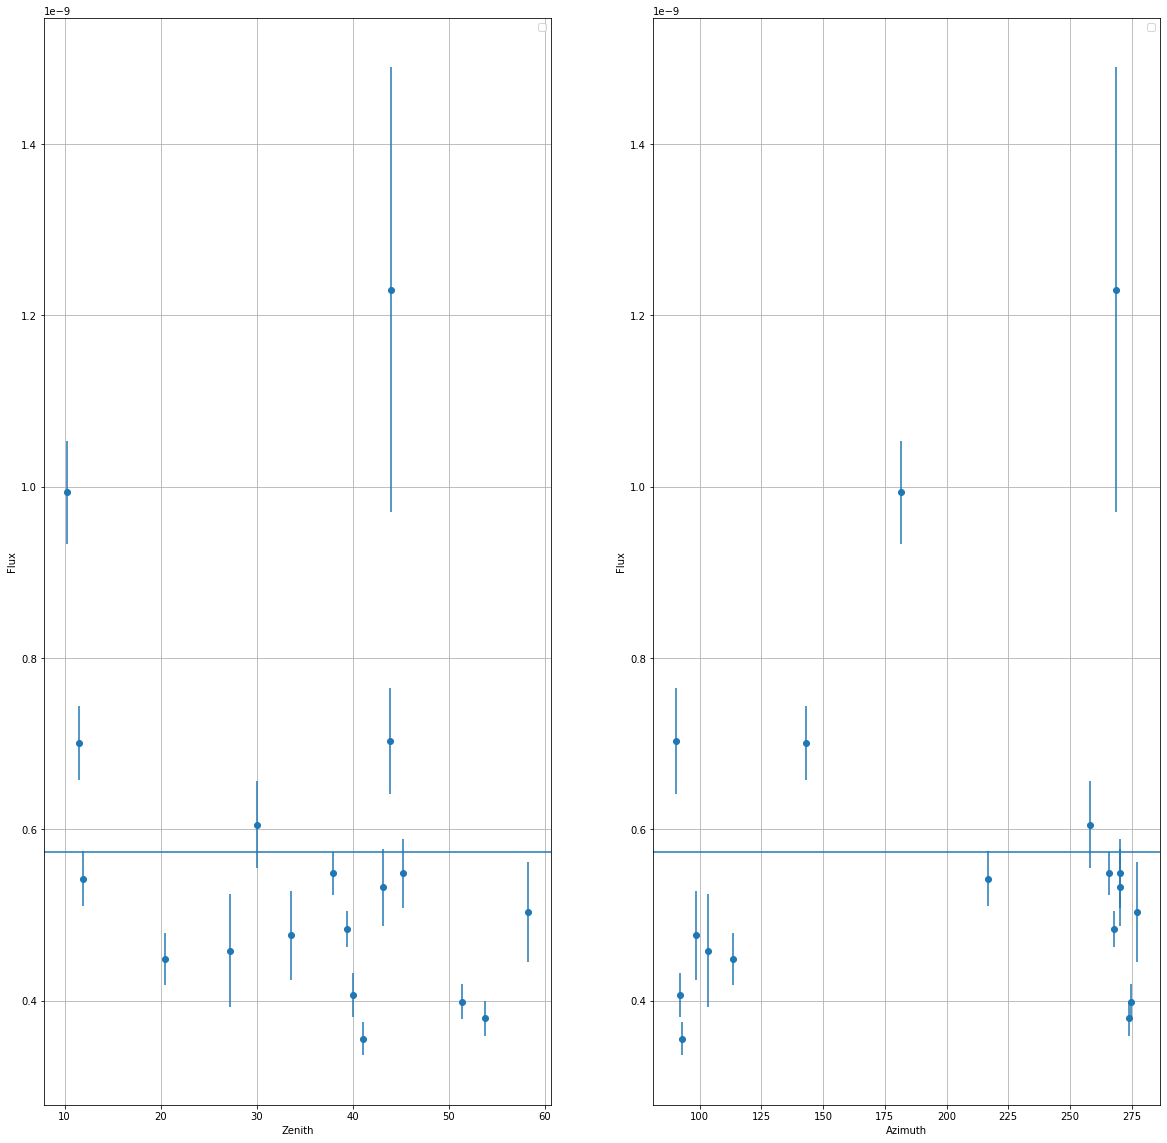

In [47]:


plt.figure(figsize=(20,20))
plt.subplot(1, 2,1)
plt.errorbar(x=list(obs_table["ZEN_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Zenith")
plt.ylabel("Flux")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.errorbar(x=list(obs_table["AZ_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Azimuth")
plt.ylabel("Flux")
plt.legend()
plt.grid()